<a href="https://colab.research.google.com/github/LeslyJaramillo/4100901-final-exam/blob/main/correcto_punto_dos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-vis

# IMPORTAR LIBRERIAS

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# CARAGAR EL DATASET

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# AUTOENCODER REGULARIZADO

In [5]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
            layers.ActivityRegularization(l1=1e-5)  # Regularización L1
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# AUTOENCODER VARIACIONAL (VAE)

In [6]:
# Definir el autoencoder variacional (VAE)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.sampling = Sampling()
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def vae_loss(self, x, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                losses.binary_crossentropy(x, reconstructed), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(x)
            loss = self.vae_loss(x, reconstructed, z_mean, z_log_var)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

# AUTOENCODER VARACIONAL

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.sampling = Sampling()
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def vae_loss(self, x, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                losses.binary_crossentropy(x, reconstructed), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(x)
            loss = self.vae_loss(x, reconstructed, z_mean, z_log_var)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}


# GANs

In [8]:
# Definir la GAN
class GAN(Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = tf.keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])
        self.discriminator = tf.keras.Sequential([
            layers.Flatten(input_shape=(28, 28, 1)),
            layers.Dense(256),
            layers.LeakyReLU(),
            layers.Dense(1, activation='sigmoid')
        ])
        self.cross_entropy = losses.BinaryCrossentropy(from_logits=True)

    def compile(self, generator_optimizer, discriminator_optimizer):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def train_step(self, images):
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

# EVALUAR LOS MODELOS

In [ ]:

# Definir el clasificador de imágenes
def build_classifier():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Entrenar y evaluar los modelos
latent_dim = 64
batch_size = 128

# Entrenar Autoencoder Regularizado
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test))

# Entrenar VAE
vae = VAE(latent_dim)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=10, batch_size=batch_size)

# Entrenar GAN
gan = GAN()
gan.compile(generator_optimizer=tf.keras.optimizers.Adam(1e-4),
            discriminator_optimizer=tf.keras.optimizers.Adam(1e-4))
gan.fit(x_train, epochs=10, batch_size=batch_size)

# Clasificación de imágenes
classifier = build_classifier()

# Clasificación con imágenes reconstruidas por el autoencoder regularizado
decoded_imgs = autoencoder.predict(x_test)
classifier.fit(decoded_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
autoencoder_acc = classifier.evaluate(decoded_imgs, y_test)[1]

# Clasificación con imágenes generadas por VAE
vae_imgs, _, _ = vae.predict(x_test)
classifier.fit(vae_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
vae_acc = classifier.evaluate(vae_imgs, y_test)[1]

# Clasificación con imágenes generadas por GAN
noise = tf.random.normal([x_test.shape[0], 100])
gan_imgs = gan.generator.predict(noise)
classifier.fit(gan_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
gan_acc = classifier.evaluate(gan_imgs, y_test)[1]

print(f"Accuracy with Autoencoder Regularized: {autoencoder_acc}")
print(f"Accuracy with VAE: {vae_acc}")
print(f"Accuracy with GAN: {gan_acc}")



Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1274 - val_loss: 0.0703
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0638 - val_loss: 0.0518
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0498 - val_loss: 0.0448
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0438 - val_loss: 0.0416
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0412 - val_loss: 0.0399
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0397 - val_loss: 0.0388
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0386 - val_loss: 0.0379
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0379 - val_loss: 0.0372
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0371 - val_loss: 0.0367
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0367 - val_loss: 0.0363
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 308.1386
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 271

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - disc_loss: 0.3301 - gen_loss: 2.6179
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - disc_loss: 0.3136 - gen_loss: 2.2388
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - disc_loss: 0.4412 - gen_loss: 1.8769
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - disc_loss: 0.5770 - gen_loss: 1.7037
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - disc_loss: 0.4997 - gen_loss: 1.8715
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - disc_loss: 0.3558 - gen_loss: 2.1257
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - disc_loss: 0.2495 - gen_loss: 2.5316
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - disc_loss: 0.3190 - gen_loss: 2.2412
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - disc_loss: 0.5953 - gen_loss: 1.5541
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - disc_loss: 0.5523 - gen_loss: 1.6343
187/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Exception ignored in: <function _xla_gc_callback at 0x782fcfe835b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


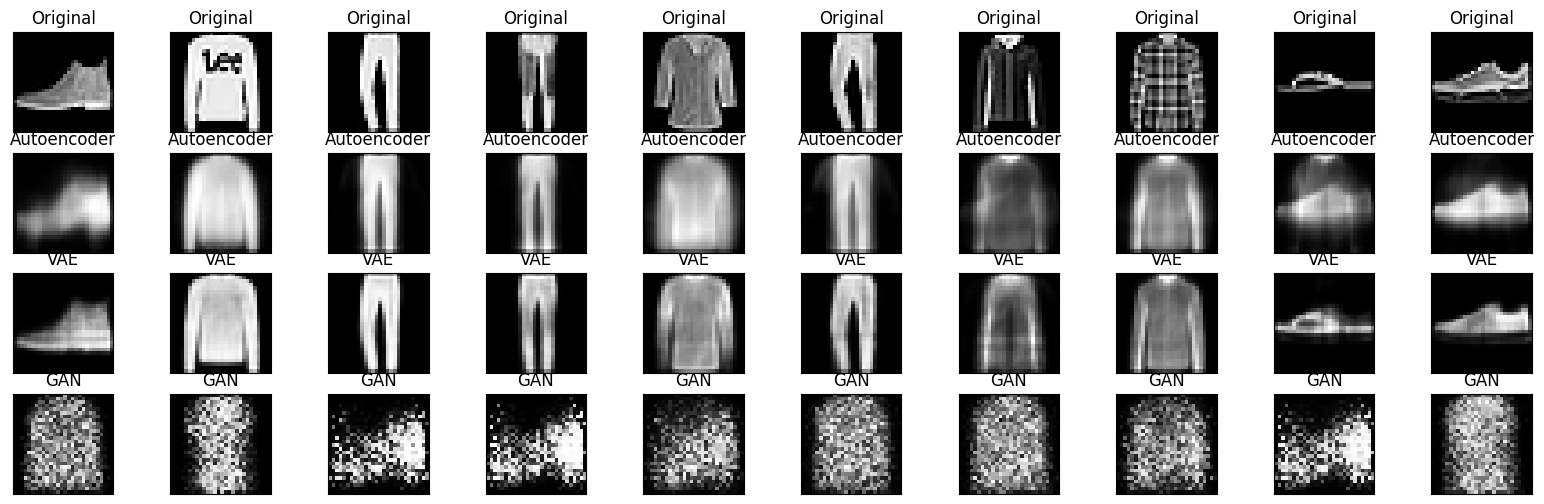

In [12]:
# Mostrar imágenes generadas y resultados
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

     # Mostrar imágenes generadas por la GAN
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(gan_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("GAN")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostrar imágenes generadas por el VAE
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(vae_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("VAE")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Mostrar imágenes reconstruidas por el Autoencoder
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Autoencoder")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)




plt.show()

# ESPACIO LATENTE

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


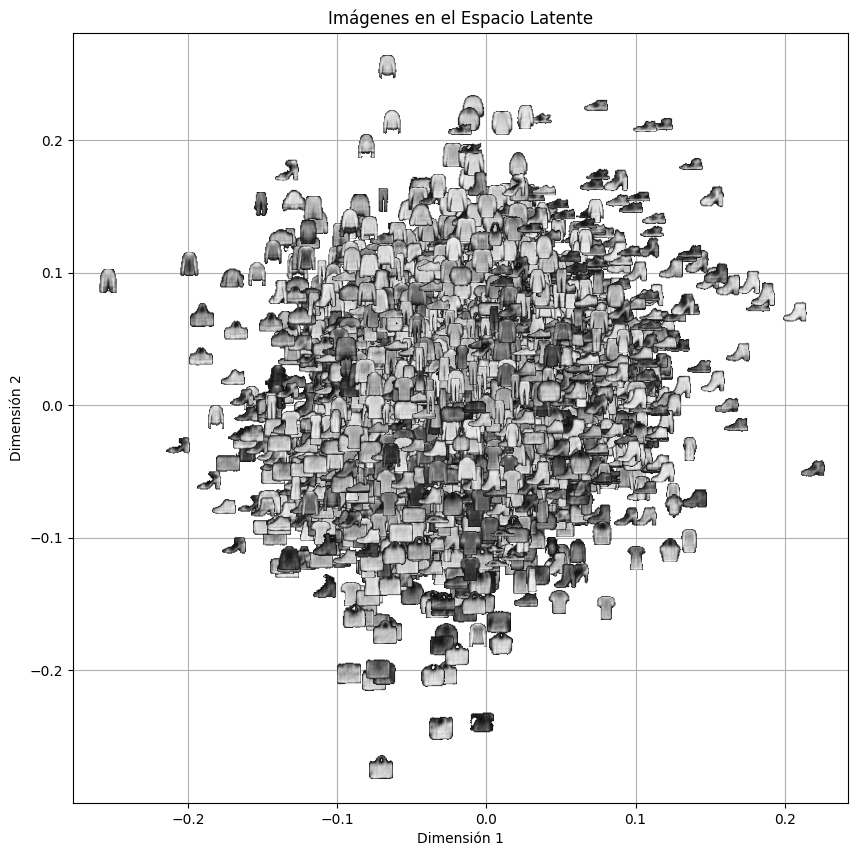

In [14]:

# Función para hacer el fondo transparente
def remove_background(image):
    rgba_image = np.zeros((image.shape[0], image.shape[1], 4))
    rgba_image[..., 0] = image[..., 0]  # Rojo
    rgba_image[..., 1] = image[..., 0]  # Verde
    rgba_image[..., 2] = image[..., 0]  # Azul
    rgba_image[..., 3] = (image[..., 0] > 0.05).astype(float)  # Alpha (transparente)
    return rgba_image

# Obtener imágenes generadas y sus posiciones en el espacio latente
vae_imgs, z_mean, _ = vae.predict(x_test)

# Aplicar la función a todas las imágenes para hacer el fondo transparente
vae_imgs_transparent = np.array([remove_background(img) for img in vae_imgs])

# Función para mostrar las imágenes en el scatter plot sin fondo
def plot_latent_images(z_mean, images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0)  # Puntos invisibles para las imágenes

    for i in range(len(images)):
        imagebox = OffsetImage(images[i], zoom=0.6, resample=True)
        ab = AnnotationBbox(imagebox, (z_mean[i, 0], z_mean[i, 1]), frameon=False)
        ax.add_artist(ab)

    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.set_title('Imágenes en el Espacio Latente')
    plt.grid(True)
    plt.show()

# Mostrar las imágenes en el espacio latente con fondo transparente
plot_latent_images(z_mean, vae_imgs_transparent)
